In [68]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from talib.abstract import CCI, DX, MACD, RSI

In [2]:
from cpl.data.processor_binance import BinanceProcessor
from cpl.data.data_processor import DataProcessor

In [19]:
ticker_list = ["BTCUSDT","ETHUSDT"]
start_date = "2021-12-15"
end_date = "2021-12-31"
time_interval = "1m"
tech_inds = ['rsi','macd']

In [20]:
p = BinanceProcessor("binance")
df = p.download_data(ticker_list, start_date, end_date, time_interval)

In [21]:
#df.set_index('time', inplace=True)

In [22]:
df = p.add_technical_indicator(df, tech_inds)

Succesfully add technical indicators


In [24]:
df.head()

,time,open,high,low,close,volume,adj_close,tic,rsi,macd
1,2021-12-15 00:01:00,48136.00,48145.09,48112.28,48129.20,9.31538,48129.20,BTCUSDT,0.000000,-0.152564
11172,2021-12-15 00:01:00,3851.72,3852.99,3848.89,3850.00,74.06350,3850.00,ETHUSDT,0.000000,-0.046218
2,2021-12-15 00:02:00,48129.20,48185.21,48126.67,48184.64,12.80545,48184.64,BTCUSDT,89.775146,1.524794
11173,2021-12-15 00:02:00,3849.99,3852.91,3849.71,3852.91,48.34810,3852.91,ETHUSDT,60.337678,0.031348
3,2021-12-15 00:03:00,48184.64,48186.88,48173.02,48178.98,6.95185,48178.98,BTCUSDT,81.710051,2.045969


In [29]:
df.shape

(22340, 10)

In [42]:
df.tic.unique()

array(['BTCUSDT', 'ETHUSDT'], dtype=object)

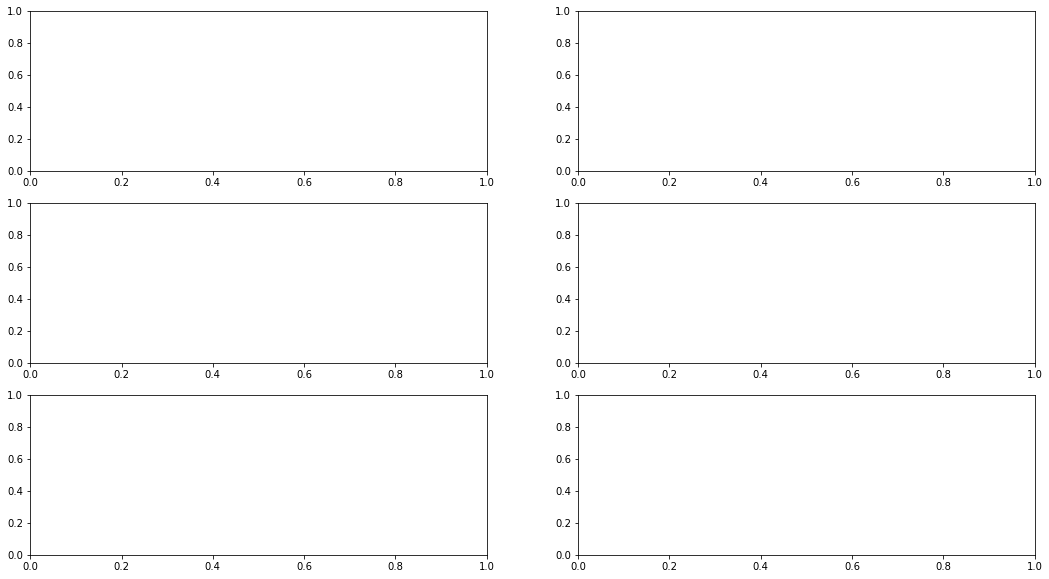

In [43]:
fig, axes = plt.subplots(3, 2, figsize=(18, 10))

In [72]:
def plot_train_data(df):
    tics = df.tic.unique()
    n_tics = tics.size
    fig, axes = plt.subplots(math.ceil(n_tics/3), 2, figsize=(18, 10))
    a = enumerate(axes.flatten())
    fig.suptitle('Prices of assets of training period')
    
    for tic in df.tic.unique():
        # price of cryptos during training period
        sns.lineplot(ax=next(a)[1], x='time',y='close',data=df[df.tic==tic]).set(title=tic)


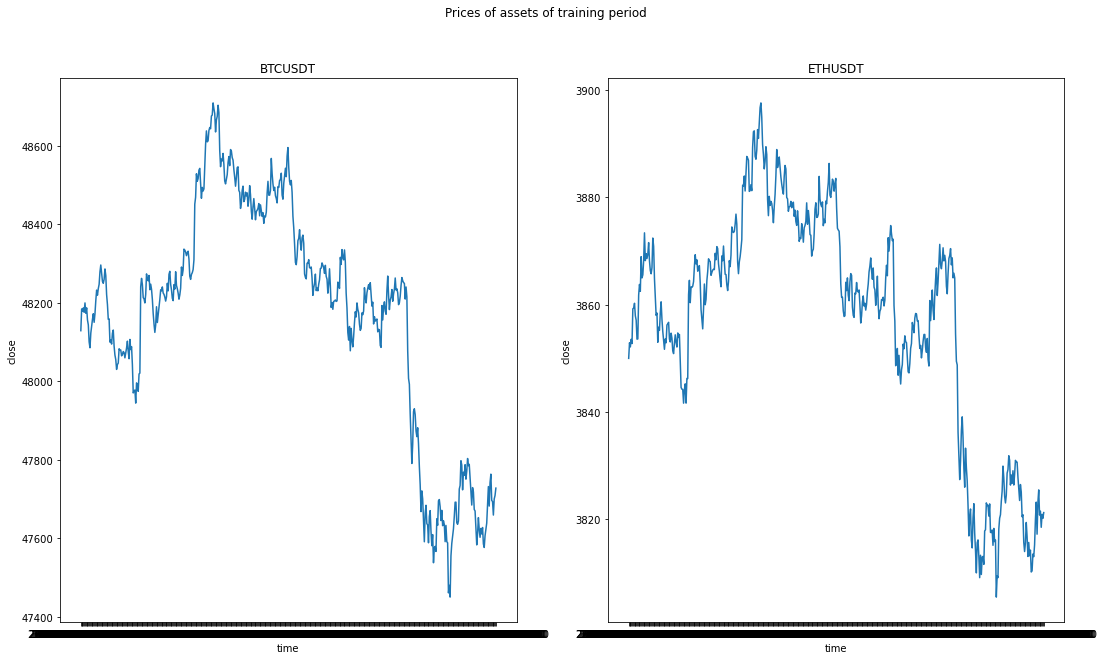

In [73]:
plot_train_data(df[:1000])

In [40]:
def define_target_condition(df):
 
    # price higher later - bad predictive results
    #df['target_cls'] = np.where(df['Adj Close'].shift(-34) > df['Adj Close'], 1, 0)    
    
    # price above trend multiple days later
    df['target_cls'] = np.where(df['Adj Close'].shift(-34) > df.EMA150.shift(-34), 1, 0)

    # important, remove NaN values
    df=df.fillna(0).copy()
    
    df.tail()
    
    return df

In [41]:
tickers = ['F', 'IBM', 'GE', 'AAPL', 'ADM',
           'XOM', 'GM','MMM','KO','PEP','SO','GS']

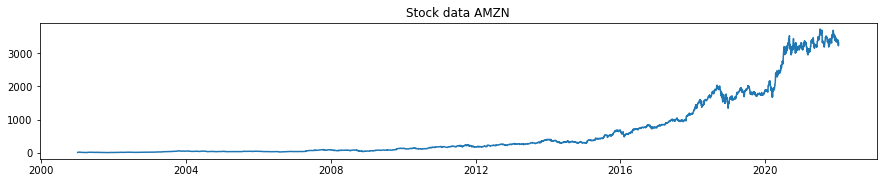

In [42]:
plot_train_data(df)

In [75]:
df.head()

,time,open,high,low,close,volume,adj_close,tic,rsi,macd
1,2021-12-15 00:01:00,48136.00,48145.09,48112.28,48129.20,9.31538,48129.20,BTCUSDT,0.000000,-0.152564
11172,2021-12-15 00:01:00,3851.72,3852.99,3848.89,3850.00,74.06350,3850.00,ETHUSDT,0.000000,-0.046218
2,2021-12-15 00:02:00,48129.20,48185.21,48126.67,48184.64,12.80545,48184.64,BTCUSDT,89.775146,1.524794
11173,2021-12-15 00:02:00,3849.99,3852.91,3849.71,3852.91,48.34810,3852.91,ETHUSDT,60.337678,0.031348
3,2021-12-15 00:03:00,48184.64,48186.88,48173.02,48178.98,6.95185,48178.98,BTCUSDT,81.710051,2.045969


In [76]:
btc = df[df.tic=="BTCUSDT"]
btc.head()

,time,open,high,low,close,volume,adj_close,tic,rsi,macd
1,2021-12-15 00:01:00,48136.00,48145.09,48112.28,48129.20,9.31538,48129.20,BTCUSDT,0.000000,-0.152564
2,2021-12-15 00:02:00,48129.20,48185.21,48126.67,48184.64,12.80545,48184.64,BTCUSDT,89.775146,1.524794
3,2021-12-15 00:03:00,48184.64,48186.88,48173.02,48178.98,6.95185,48178.98,BTCUSDT,81.710051,2.045969
4,2021-12-15 00:04:00,48178.99,48189.66,48156.08,48187.29,17.31493,48187.29,BTCUSDT,83.984898,2.616768
5,2021-12-15 00:05:00,48187.29,48187.70,48162.70,48176.16,16.00392,48176.16,BTCUSDT,71.209945,2.434784


### Model of open, high, low, close, volume, rsi, macd -> (1, 2, 3) -> 1

In [ ]:
class linReg(nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = nn.Linear(inputSize, 256)
        self.linear = nn.Linear(256, 128)
        self.linear = nn.Linear(128, 64)
        self.linear = nn.Linear(64, 1)
        
    def forward(self, x):
        out = self.linear(x)
        return out